# 03_ADVANCED PREDICTIONS - CLV, CHURN & SENTIMENT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report,
    recall_score,
    precision_score
)

from xgboost import XGBRegressor, XGBClassifier

sns.set_style("whitegrid")

## 1. LOAD DATA

In [2]:
df = pd.read_csv("cleaned_data.csv")
print("Shape:", df.shape)

Shape: (3900, 28)


## 2. ONE-HOT ENCODING

In [3]:
categorical_cols = ["Gender", "Category", "Season"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## 3. CUSTOMER LIFETIME VALUE (CLV) PREDICTION

In [4]:
print("\n===== CLV PREDICTION =====")

TIME_HORIZON_YEARS = 2

subscription_bonus = df["Subscription Status"].map({"Yes": 0.3, "No": 0.0})
loyalty_multiplier = 1 + (df["RFM_Score"] / df["RFM_Score"].max())

df["CLV"] = (
    df["Purchase Amount (USD)"]
    * df["Previous Purchases"]
    * (1 + subscription_bonus)
    * loyalty_multiplier
) * TIME_HORIZON_YEARS

df["CLV_log"] = np.log1p(df["CLV"])


===== CLV PREDICTION =====


In [5]:
clv_features = [
    "Age",
    "Previous Purchases",
    "Discount_Sensitivity",
    "RFM_Score"
] + [col for col in df.columns if col.startswith(("Gender_", "Category_", "Season_"))]

X = df[clv_features]
y = df["CLV_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_clv = StandardScaler()
X_train_sc = scaler_clv.fit_transform(X_train)
X_test_sc = scaler_clv.transform(X_test)

In [6]:
clv_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

clv_model.fit(X_train_sc, y_train)

y_pred_log = clv_model.predict(X_test_sc)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

RMSE: 1825.88
MAE:  1235.31
R²:   0.8415


In [7]:
df["Predicted_CLV"] = np.expm1(clv_model.predict(scaler_clv.transform(X)))

df["CLV_Tier"] = pd.qcut(
    df["Predicted_CLV"],
    q=3,
    labels=["Bronze", "Silver", "Gold"]
)

print("\nCLV Tier Distribution:")
print(df["CLV_Tier"].value_counts())


CLV Tier Distribution:
CLV_Tier
Bronze    1300
Silver    1300
Gold      1300
Name: count, dtype: int64


## 4. CHURN PREDICTION

In [8]:
print("\n===== CHURN PREDICTION =====")

low_freq = df["Frequency of Purchases"].isin(["Quarterly", "Annually"])
low_rfm = df["RFM_Score"] <= df["RFM_Score"].quantile(0.30)
no_sub = df["Subscription Status"] == "No"
low_rating = df["Review Rating"] <= 3
no_promo = df["Promo Code Used"] == "No"

df["Churn"] = (
    (low_freq & low_rfm) |
    (no_sub & low_rating & no_promo)
).astype(int)

print("Churn Rate:", df["Churn"].mean())


===== CHURN PREDICTION =====
Churn Rate: 0.3728205128205128


In [9]:
churn_features = [
    "Age",
    "Previous Purchases",
    "Discount_Sensitivity",
    "RFM_Score",
    "Predicted_CLV"
] + [col for col in df.columns if col.startswith(("Gender_", "Category_", "Season_"))]

Xc = df[churn_features]
yc = df["Churn"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

scaler_churn = StandardScaler()
Xc_train_sc = scaler_churn.fit_transform(Xc_train)
Xc_test_sc = scaler_churn.transform(Xc_test)

In [10]:
churn_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

churn_model.fit(Xc_train_sc, yc_train)

yc_pred = churn_model.predict(Xc_test_sc)

print(classification_report(yc_test, yc_pred))

print("Recall:", recall_score(yc_test, yc_pred))
print("Precision:", precision_score(yc_test, yc_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       489
           1       0.77      0.70      0.73       291

    accuracy                           0.81       780
   macro avg       0.80      0.79      0.79       780
weighted avg       0.81      0.81      0.81       780

Recall: 0.697594501718213
Precision: 0.7718631178707225


In [11]:
df["Churn_Probability"] = churn_model.predict_proba(
    scaler_churn.transform(Xc)
)[:,1]

df["Churn_Risk"] = (df["Churn_Probability"] > 0.45).astype(int)

## 5. VALUE × RISK QUADRANT

In [12]:
df["Value_Risk_Quadrant"] = np.where(
    (df["CLV_Tier"]=="Gold") & (df["Churn_Risk"]==1),
    "High Value - High Risk",
    np.where(
        (df["CLV_Tier"]=="Gold") & (df["Churn_Risk"]==0),
        "High Value - Low Risk",
        np.where(
            (df["CLV_Tier"]!="Gold") & (df["Churn_Risk"]==1),
            "Low Value - High Risk",
            "Low Value - Low Risk"
        )
    )
)

print("\nValue × Risk Quadrant Distribution:")
print(df["Value_Risk_Quadrant"].value_counts())


Value × Risk Quadrant Distribution:
Value_Risk_Quadrant
Low Value - High Risk     1419
High Value - Low Risk     1280
Low Value - Low Risk      1181
High Value - High Risk      20
Name: count, dtype: int64


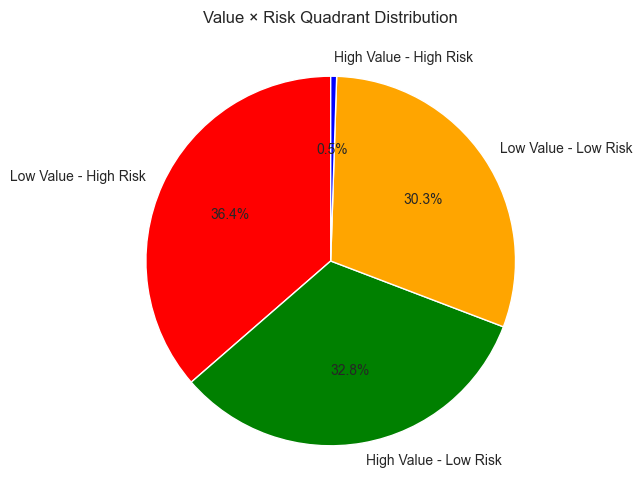

In [13]:
plt.figure(figsize=(10, 6))
quadrant_counts = df["Value_Risk_Quadrant"].value_counts()
colors = ['red', 'green', 'orange', 'blue']
plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Value × Risk Quadrant Distribution")
plt.show()

## 6. SENTIMENT ANALYSIS

In [14]:
print("\n===== SENTIMENT MODEL =====")

df["Sentiment_Label"] = pd.cut(
    df["Review Rating"],
    bins=[0,2.9,3.9,5],
    labels=[0,1,2]
)

sent_features = [
    "Age",
    "Previous Purchases",
    "Discount_Sensitivity"
] + [col for col in df.columns if col.startswith(("Category_", "Season_"))]

Xs = df[sent_features]
ys = df["Sentiment_Label"].astype(int)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, ys, test_size=0.2, random_state=42, stratify=ys
)

scaler_sent = StandardScaler()
Xs_train_sc = scaler_sent.fit_transform(Xs_train)
Xs_test_sc = scaler_sent.transform(Xs_test)


===== SENTIMENT MODEL =====


In [15]:
sent_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

sent_model.fit(Xs_train_sc, ys_train)

ys_pred = sent_model.predict(Xs_test_sc)

print(classification_report(ys_test, ys_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       137
     Neutral       0.38      0.43      0.40       314
    Positive       0.43      0.56      0.48       329

    accuracy                           0.41       780
   macro avg       0.27      0.33      0.30       780
weighted avg       0.33      0.41      0.37       780



## 7. FEATURE IMPORTANCE VISUALIZATION

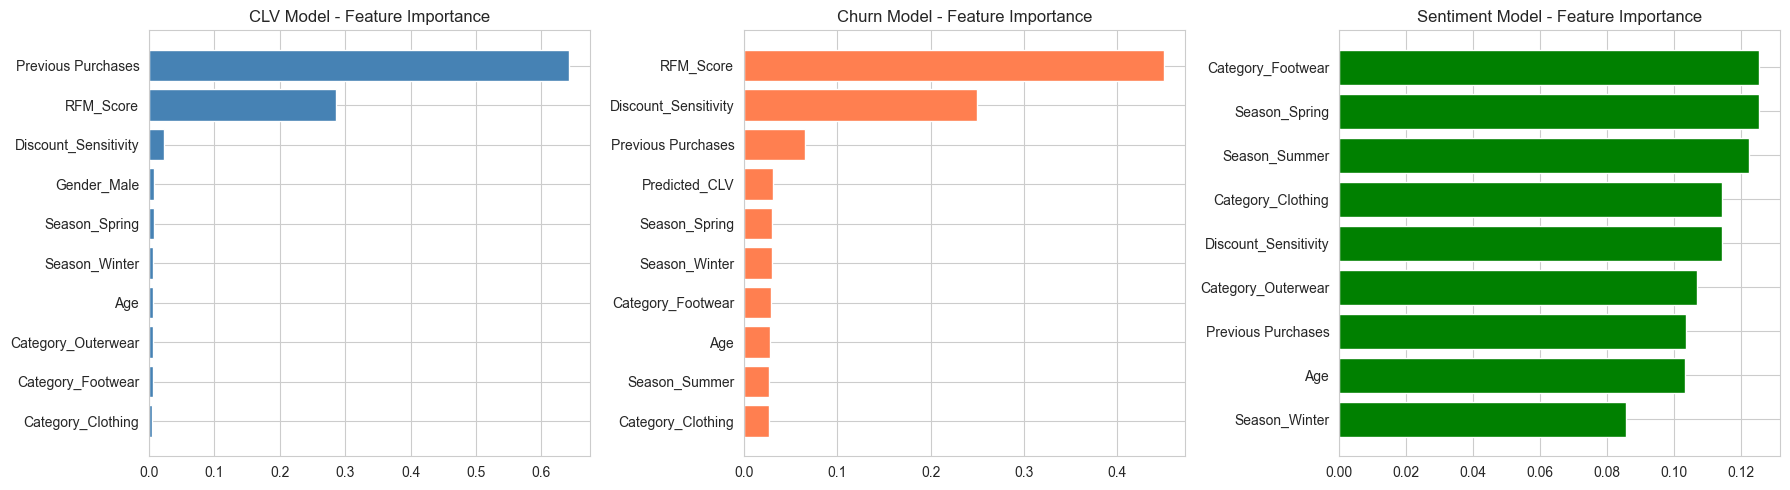

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

clv_importance = pd.Series(clv_model.feature_importances_, index=clv_features).sort_values(ascending=False).head(10)
axes[0].barh(clv_importance.index, clv_importance.values, color='steelblue')
axes[0].set_title("CLV Model - Feature Importance")
axes[0].invert_yaxis()

churn_importance = pd.Series(churn_model.feature_importances_, index=churn_features).sort_values(ascending=False).head(10)
axes[1].barh(churn_importance.index, churn_importance.values, color='coral')
axes[1].set_title("Churn Model - Feature Importance")
axes[1].invert_yaxis()

sent_importance = pd.Series(sent_model.feature_importances_, index=sent_features).sort_values(ascending=False).head(10)
axes[2].barh(sent_importance.index, sent_importance.values, color='green')
axes[2].set_title("Sentiment Model - Feature Importance")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## 8. FINAL SUMMARY

In [19]:
print("\n" + "="*50)
print("ADVANCED PREDICTIONS SUMMARY")
print("="*50)

print("\n--- CLV Model ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

print("\n--- Churn Model ---")
print(f"Churn Rate: {df['Churn'].mean():.2%}")
print(f"Recall: {recall_score(yc_test, yc_pred):.4f}")
print(f"Precision: {precision_score(yc_test, yc_pred):.4f}")


print("\n--- Value × Risk Quadrant ---")
print(df["Value_Risk_Quadrant"].value_counts())

print("\n" + "="*50)
print("Analysis Complete!")
print("="*50)


ADVANCED PREDICTIONS SUMMARY

--- CLV Model ---
RMSE: 1825.88
MAE: 1235.31
R²: 0.8415

--- Churn Model ---
Churn Rate: 37.28%
Recall: 0.6976
Precision: 0.7719

--- Value × Risk Quadrant ---
Value_Risk_Quadrant
Low Value - High Risk     1419
High Value - Low Risk     1280
Low Value - Low Risk      1181
High Value - High Risk      20
Name: count, dtype: int64

Analysis Complete!
